In [1]:
import torch
import torch.nn as nn
import torch_geometric as pyg
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from utils import load_pickle
from dataclass_torch import GraphFloorplanUNet
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

In [2]:
def visualize_result(boundary_image_np, gt_image_np, predicted_np):
    # I used the colors from the github repository
    colors = ['#1f77b4','#e6550d','#fd8d3c','#fdae6b','#fdd0a2','#72246c','#5254a3','#6b6ecf','#2ca02c','#000000','white']
    cmap = ListedColormap(colors)
    
    # Plot the boundary image, prediction, and ground truth
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(boundary_image_np, cmap='gray')
    axs[0].set_title('Boundary Image')
    axs[0].axis('off')

    predicted_np[predicted_np == 13] = 10
    axs[1].imshow(predicted_np, cmap=cmap)
    axs[1].set_title('Prediction')
    axs[1].axis('off')

    gt_image_np[gt_image_np == 13] = 10
    im = axs[2].imshow(gt_image_np, cmap=cmap)
    axs[2].set_title('Ground Truth')
    axs[2].axis('off')

    # Create legend
    legend_labels = {
        'Bedroom': 0,
        'Livingroom': 1,
        'Kitchen': 2,
        'Dining': 3, 
        'Corridor': 4,
        'Stairs': 5,
        'Storeroom': 6,
        'Bathroom': 7,
        'Balcony': 8,
        'Structure': 9,
        'Background': 10  # Adjusted the value to match the colors list index
    }

    # Create own legends using patch
    legend_handles = [Patch(color=colors[value], label=label) for label, value in legend_labels.items()]
    plt.legend(handles=legend_handles, bbox_to_anchor=(-1, 0.0), loc='upper center', ncol=6, fontsize=14)
    plt.tight_layout()
    plt.show()

def infer(model, boundary_image, graph_pyg):
    model.eval()

    with torch.no_grad():
        # Perform inference
        output = model(boundary_image.unsqueeze(0).cuda(), graph_pyg.to('cuda'))
        predicted = torch.argmax(output, dim=1)

        # Convert tensors to numpy arrays
        predicted_np = predicted.cpu().numpy()[0]

    return predicted_np


def load_sample(graph_path, struct_path):
    transform = transforms.ToTensor()

    # Load struct image
    struct_in = np.load(struct_path)
    boundary_image = struct_in.astype(np.uint8) 
    boundary_image = transform(boundary_image)

    # Load graph
    num_room_types = 4  
    num_connection_types = 3 
    connection_dic = {'door': 0, 'entrance': 1, 'passage': 2}
    
    graph_nx = load_pickle(graph_path)
    graph_nx.graph['struct'] = struct_in[np.newaxis, ...]
    
    node_features = []
    for _, node_data in graph_nx.nodes(data=True):
        node_type = node_data['zoning_type']
        node_feature = [0]*num_room_types
        node_feature[node_type] = 1
        node_features.append(node_feature)
    
    edge_features = []
    for _, _, edge_data in graph_nx.edges(data=True):
        connection_type = connection_dic[edge_data['connectivity']]
        edge_feature = [0]*num_connection_types
        edge_feature[connection_type] = 1
        edge_features.append(edge_feature)

    # Convert to PyG graph
    graph_pyg = pyg.utils.from_networkx(graph_nx)
    graph_pyg.x = torch.tensor(node_features, dtype=torch.float)  # node features
    graph_pyg.edge_attr = torch.tensor(edge_features, dtype=torch.float)  # edge features
    
    return boundary_image, graph_pyg


In [3]:
# Create the model
num_node_features = 4
input_nc = 3
output_nc = 11

model = GraphFloorplanUNet(num_node_features, input_nc, output_nc).cuda()

model.load_state_dict(torch.load('./results/05020927/model_checkpoint_epoch_60.pt'))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/ignatiocalvin/anaconda3/envs/plangen/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/nv/9r2j07yj4w7gpdqz5zp13j3m0000gn/T/ipykernel_25725/2243037618.py", line 6, in <module>
    model = GraphFloorplanUNet(num_node_features, input_nc, output_nc).cuda()
  File "/Users/ignatiocalvin/anaconda3/envs/plangen/lib/python3.9/site-packages/torch/nn/modules/module.py", line 915, in cuda
    return self._apply(lambda t: t.cuda(device))
  File "/Users/ignatiocalvin/anaconda3/envs/plangen/lib/python3.9/site-packages/torch/nn/modules/module.py", line 779, in _apply
    module._apply(fn)
  File "/Users/ignatiocalvin/anaconda3/envs/plangen/lib/python3.9/site-packages/torch/nn/modules/module.py", line 779, in _apply
    module._apply(fn)
  File "/Users/ignatiocalvin/anaconda3/envs/plangen/lib/python3.9/site-packages/torch/nn/modules/module.py",

In [6]:
id = 0

In [8]:
# Load sample
graph_path = './dataset/val/graph_in/'+str(id)+'.pickle'
struct_path = './dataset/val/struct_in/'+str(id)+'.npy'
boundary_image, graph_pyg = load_sample(graph_path, struct_path)


boundary_image = boundary_image.cuda()
graph_pyg = graph_pyg.cuda()

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 64, 512, 512])
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([1, 64, 512, 512])
ReLU(inplace=True)
torch.Size([1, 64, 512, 512])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 64, 512, 512])
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([1, 64, 512, 512])
ReLU(inplace=True)
torch.Size([1, 64, 512, 512])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([1, 64, 256, 256])
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 128, 256, 256])
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([1, 128, 256, 256])
ReLU(inplace=True)
torch.Size([1, 128, 256, 256])
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 128, 256, 256])
BatchNorm2d(128, eps=1e-05,

/var/folders/nv/9r2j07yj4w7gpdqz5zp13j3m0000gn/T/ipykernel_71196/2690238389.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


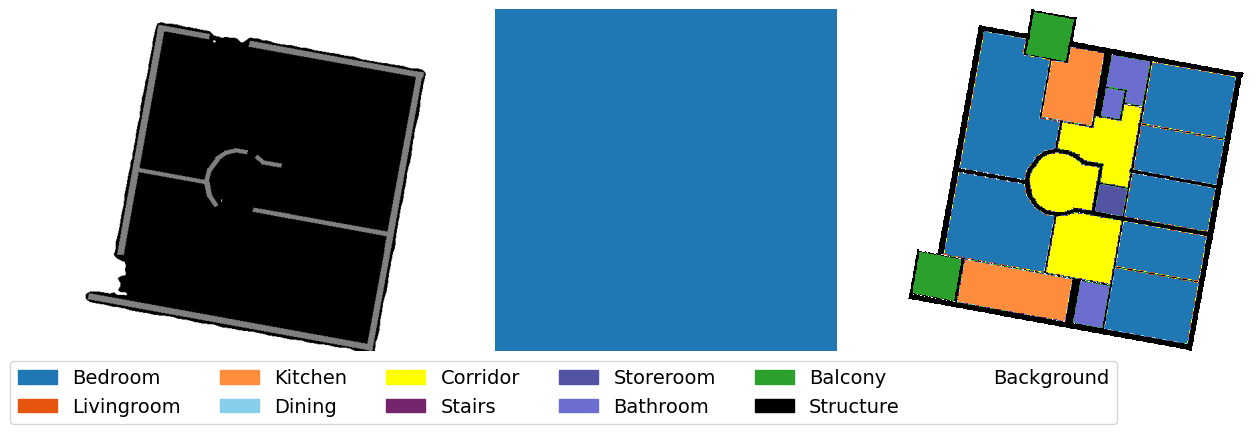

In [9]:
# Perform inference
predicted = infer(model, boundary_image, graph_pyg)

# Load ground truth image
full_path = './dataset/val/full_out/'+str(id)+'.npy'
gt_image_np = np.load(full_path)[..., 0]

raw_boundary_image_path = './dataset/val/struct_in/'+str(id)+'.npy'
boundary_image_np = np.load(raw_boundary_image_path)
boundary_img = boundary_image_np[..., 0].astype(np.uint8)

# Visualize the result
visualize_result(boundary_img, gt_image_np, predicted)